## Deep Learning-Based Automated Segmentation of Resection Cavities on Postsurgical Epilepsy MRI
T. Campbell Arnold1,2 *, Ramya Muthukrishnan2,3 *, Akash R. Pattnaik1,2, Adam Gibson2, Nishant Sinha2, Sandhitsu R. Das4, Brian Litt1,2,5, Dario J. Englot6-9, Victoria L. Morgan7-9, Kathryn A. Davis2,5, Joel M. Stein4
*These authors contributed equally
1. Department of Bioengineering, School of Engineering & Applied Science, University of Pennsylvania, Philadelphia, PA, 19104, USA
2. Center for Neuroengineering and Therapeutics, University of Pennsylvania, Philadelphia, PA, 19104, USA
3. Department of Computer Science, University of Pennsylvania, Philadelphia, PA, 19104, USA
4. Department of Radiology, Perelman School of Medicine, University of Pennsylvania, Philadelphia, PA, 19104, USA
5. Department of Neurology, Perelman School of Medicine, University of Pennsylvania, Philadelphia, PA, 19104, USA
6. Department of Neurological Surgery, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
7. Department of Radiology and Radiological Sciences, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
8. Department of Biomedical Engineering, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA
9. Institute of Imaging Science, Vanderbilt University Medical Center, Nashville, Tennessee 37232, USA


#### Synopsis
We present a tool for automatic resection cavity segmentation on postoperative MRI of temporal lobe epilepsy patients. Applications include quantification of postoperative remnant brain volumes, correction of deformable registration, and localization of removed brain regions for network modeling.


## Abstract

#### Purpose
To automate resection cavity segmentation on postoperative MRI of epilepsy patients and quantify removed brain structures.

#### Materials and Methods
This retrospective study included postoperative T1-weighted MRI from 45 temporal lobe epilepsy (TLE) patients that underwent resective surgery. The resection site was manually segmented and reviewed by a neuroradiologist (JMS). A U-Net convolutional neural network was trained to segment surgical resection in axial slices. The algorithm was trained using 5-fold cross validation, with data partitioned into training (N=28), testing (N=9), and validation (N=9) sets. Algorithm performance was measured using Dice-Sørensen coefficient (DSC), Hausdorff distance, and volume estimates. Additionally, we demonstrate a fully automated pipeline that compares resection segmentations with preoperative imaging to report remnant brain structures after surgery.

#### Results
The median DSC between manual and automated segmentations was 0.80 (0.12 interquartile range), which approaches inter-rater reliability between radiologists (0.84-0.86) as reported in the literature. Median 50% and 95% Hausdorff distance was 1.0 mm and 4.1 mm respectively, indicating high segmentation boundary confidence. Automated and manual resection volume estimates were highly correlated (R=0.85, p<0.0001). Automated segmentations overlapped manual labels in all 45 subjects, indicating a low false negative rate. In control subjects (n=5), no resection was detected (i.e. 0% false positives). There was strong agreement between automated and manual estimates of the postoperative hippocampal remnant volume (R=0.82, p<0.0001).

#### Conclusion
We applied deep learning to segment temporal lobe resections with performance approaching inter-rater reliability. Automated segmentation permitted accurate quantification of postoperative brain volumes after epilepsy surgery.

#### Summary
We present a tool for automatic resection cavity segmentation on postoperative MRI of temporal lobe epilepsy patients. Applications include quantification of postoperative remnant brain volumes, correction of deformable registration, and localization of removed brain regions for network modeling.


## Introduction
Epilepsy is a neurological disorder characterized by recurrent seizures that affects sixty-five million people worldwide (1). Temporal lobe epilepsy (TLE) is the most common form of epilepsy, with a prevalence of 8.9 cases per 100,000 people per year in the US (2). Surgical removal of the epileptic focus is the recommended treatment for drug-resistant TLE, however only about 58% of patients experience seizure-freedom one year postoperatively (3). Quantitative assessments of resection extent have been identified as significant predictors of surgical outcome (4–6). Automated methods for quantifying resection extent would be of significant interest to the epilepsy clinical and research communities.

Retrospective studies attempt to predict surgical outcome of TLE patients using a variety of manual methods which are susceptible to bias due to inter-rater variability. Simple measures, such as which brain regions fall within the resection zone, have been identified as a positive predictor of postoperative seizure freedom (5,7). More complex methods mimic surgical resection on brain network models to predict postoperative seizure freedom (8,9). The resected brain regions are often determined through manual segmentation or visual inspection (10,11). Time-consuming and error-prone manual methods for determining resected tissue limit clinical adoption of these tools. An automated method for delineating resection cavities would be of substantial clinical and research interest, with potential to increase the accuracy of predictive models, evaluate alternative surgical strategies, and improve patient outcomes.

Recent advances in convolutional neural networks (CNNs) have led to vast improvements in classification and segmentation of medical imaging (12). Neural network architectures designed for segmentation, such as U-Net, have been successfully applied to problems from a wide range of specialties, including radiology, pathology, and dermatology (13). A primary goal for many of these tools is the automation of tedious, time-consuming tasks in medicine (14). In epilepsy patient care, predictive models of resection extent have not been adopted clinically in part due to their reliance on manual segmentation of resections or visual inspection by researchers. Manual segmentation of resection cavities is time-consuming and variable across institutions. The lack of automated resection segmentation methods prevents quantitative neuroimaging analyses from being integrated into epilepsy patient care (15).

Therefore, the goal of our study was to develop a fully automated method for segmenting resection volumes and quantifying resected brain tissues in TLE patients. This tool can evaluate successful removal of surgical targets and improve predictive models of surgical outcome.


## Import python modules

In [30]:
%%capture

# !pip install xlrd
# !pip install antspyx==0.2.9 # install ANTs python
# !pip install antspynet==0.1.3 # install ANTs python networks (for longitudinal cortical thickness)
# !pip install tensorflow==2.6.2
# !pip install keras==2.6.0

# import relevant modules
import ants
import numpy as np
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import os
import tensorflow as tf
import antspynet
import shutil

In [9]:
%%capture

# Update OpenSSL for python 3.6.0
# https://stackoverflow.com/questions/42098126/mac-osx-python-ssl-sslerror-ssl-certificate-verify-failed-certificate-verify
#

!pip install certifi

# sample script to install or update a set of default Root Certificates
# for the ssl module.  Uses the certificates provided by the certifi package:
# https://pypi.python.org/pypi/certifi
import os.path
import ssl
import stat
import subprocess
import sys
import certifi

STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )
def main():
    openssl_dir, openssl_cafile = os.path.split(
        ssl.get_default_verify_paths().openssl_cafile)
    print(" -- pip install --upgrade certifi")
    subprocess.check_call([sys.executable,
        "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])
    import certifi
    # change working directory to the default SSL directory
    os.chdir(openssl_dir)
    relpath_to_certifi_cafile = os.path.relpath(certifi.where())
    print(" -- removing any existing file or link")
    try:
        os.remove(openssl_cafile)
    except FileNotFoundError:
        pass
    print(" -- creating symlink to certifi certificate bundle")
    os.symlink(relpath_to_certifi_cafile, openssl_cafile)
    print(" -- setting permissions")
    os.chmod(openssl_cafile, STAT_0o775)
    print(" -- update complete")
if __name__ == '__main__':
    main()
    os.chdir(r'/Users/tcarnold/Desktop/Everything/CNT/Projects/DeepResection/scripts') 

## Helper Functions

In [10]:
def iqr(x):
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    return iqr

In [11]:
# for comparing continuous stats across sites
def basic_stats(df,var):
    
    print(var)
    print('Mean (std): ' + str( np.round( np.mean( df[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr(df[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df[var] ) , 2 ) ) )
    print()


In [21]:
# For comparing ATL and SAH
def compare_stats(df1,label1,df2,label2,var):
    
    print(var)
    print(label1)
    print('Mean (std): ' + str( np.round( np.mean( df1[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df1[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df1[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr( df1[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df1[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df1[var] ) , 2 ) ) )
    print(label2)
    print('Mean (std): ' + str( np.round( np.mean( df2[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df2[var]) , 2 ) ) )
    print('Median (IQR): ' + str( np.round( np.median( df2[var] ) , 2 ) ) + ' +/- ' + str( np.round( iqr( df2[var]) , 2 ) ) )
    print('Max: ' + str( np.round( np.max( df2[var] ) , 2 ) ) )
    print('Min: ' + str( np.round( np.min( df2[var] ) , 2 ) ) )
    ttest_results = scipy.stats.ttest_ind( df1[var], df2[var], nan_policy='omit')
    print(ttest_results)
    print()
    

In [40]:
# discrete chi squared analysis
def chi_sq_test(df,var):

    crosstab = pd.crosstab(df["site"], df[var])
    results = stats.chi2_contingency(crosstab)
    print('X^2 = ' + str(results[0]) + ', p = ' + str(results[1]))
    

## Materials and Methods

#### Data collection
T1-weighted images (N=45) were collected from temporal lobe epilepsy (TLE) patients that underwent surgery at the Hospital of the University of Pennsylvania (HUP) or Vanderbilt University Medical Center (VUMC). Internal Review Boards of each institution approved this study, and all patients gave informed consent. Patients at HUP (N=22) were imaged using a Siemens 3T scanner. T1-weighted sequence parameters were 1mm isotropic, TE=3.87ms, TR=1.62s, and flip-angle=15. Patients at VUMC (N=23) were imaged using a Phillips 3T scanner. T1-weighted sequence parameters were 1mm isotropic, TE=4.61ms, TR=8.9ms, and flip-angle=8. All images were collected at least 5 months postoperatively to avoid peri-surgical swelling. Inclusion criteria were: 1) TLE patients that underwent resection, 2) whole-brain, isotropic T1-weighted imaging at least 5 months postoperatively, and 3) only one contiguous resection site. Additionally, T1-weighted images were collected from five healthy participants at HUP using the same protocol.

#### Data preprocessing
The resection site in each T1-weighted image was manually segmented in ITK-SNAP (16) and reviewed by a board certified neuroradiologist (JMS). Each 3D volumetric image was normalized to a standard intensity range [0-1], and 2D axial slices were output as 256x256 Portable Networks Graphic (PNG) files for training.

#### Model Architecture
A U-Net CNN architecture was used to segment resections (13). Model construction and training was carried out using the Keras API with TensorFlow backend (17). The model training script was adapted from an open-source U-net segmentation project (18) to our model architecture and run on an independent server using a Titan-X GPU. The U-Net architecture consists of an encoder that captures contextual information and a decoder that captures localization information to output a predicted mask. Our model architecture replaced the traditional U-Net encoder with the EfficientNet B1 network encoder backbone, and initial encoder weights were pre-trained on ImageNet data (19,20).

#### Model Training
The model performed binary segmentation of resections (i.e. 1 = resected, 0 = not resected) in axial slices of T1-weighted images. During model training, 5-fold cross validation was employed with data divided into training, validation, and test sets (3:1:1 split). All axial slices for a given subject were contained within a single set (i.e. training, validation, or testing). The 5-fold approach permits each subject in the dataset to be included in the test set once. Models were trained for 50 epochs using the Adam optimizer, a learning rate of 1e-4, and a batch size of 16. Data augmentation was employed during training to increase model generalizability (21). Augmentation included random horizontal and vertical flips, rotations up to 10 degrees, and horizontal and vertical shifts up to 10% of image width and height.

#### Post processing
Segmentations output by the CNN underwent two post processing steps: (1) assembly of 3D volumes from 2D slice segmentations and (2) connected components analysis to remove isolated voxels.

#### Model Evaluation
Segmentation performance was primarily evaluated using the Dice-Sørensen coefficient (DSC) (22). DSC measures the overlap between manual segmentations X and automated  segmentations Y, by computing 2|X∩Y|/(|X|+|Y|), illustrated in Figure 1.
Performance for DSC  ranges from 0 (no overlap) to 1 (perfect match). Hyperparameter optimization was driven by DSC maximization in the validation set. To assess model generalizability to novel images, all reported DSC were calculated on held-out test datasets.
Subtle changes to performance measures can result in significant differences when ranking algorithms (23). To provide a holistic view of model performance, we report multiple metrics and descriptive statistics. We report two secondary measures, Hausdorff distance and total resection volume (Figure 1). Hausdorff distance compares actual and predicted segmentation boundaries and reports the farthest distance between adjacent boundary points. This measure characterizes the segmentation border reliability. Several variants of the Hausdorff distance are reported in the literature (24,25). For comparison we report 50% and 95% Hausdorff distances. Additionally, the relationship between manual and automated resection volumes was plotted for each subject and we report the Pearson’s correlation coefficient between these variables.

#### Quantifying surgical remnants
Postoperative remnant volumes, such as the hippocampal remnant, have predictive value for TLE surgical outcome (7). We further developed a pipeline that estimates postoperative remnant brain structures. The pipeline takes a patient’s preoperative and postoperative T1 brain MRI as input and generates a PDF report or an interactive web-based report of estimated resection impact on brain structures (Figure 2). Preoperative imaging was coregistered to post-operative imaging and segmented into functional brain regions using Advanced Normalization Tools (ANTs) (26). Images were coregistered using a symmetric normalization transformation, with cross-correlation as optimization metric and cost-function masking of the resection zone to mitigate image distortion [cite]. Proper image coregistration was verified manually. The resection cavity was segmented both manually and using the automated algorithm described here. The intersection of preoperative brain segmentations and the postoperative resection segmentation was used to estimate remnant brain volumes. We correlated hippocampal remnant volume estimates between manual and automated resection segmentation methods.

#### Code availability
All code related to model design and postoperative volume estimation can be found at: https://github.com/tcama/DeepResection.


## Results



#### Patient characteristics
Our dataset included 45 patients who underwent surgery for localization-related epilepsy across two institutions, Hospital of the University of Pennsylvania (HUP, N=22) and Vanderbilt University Medical Center (VUMC, N=23). Patients were age-matched across institution (HUP: 39.2 ± 12.0 years, VUMC: 39.5 ± 12.7 years) and were treated with either anterior temporal lobectomy (ATL, N=28), selective amygdalohippocampectomy (SAH, N=15), or hippocampal laser ablation (N=2). Demographic information is available in Table 1.


In [13]:
# load in patient demographic information

demo_df = pd.read_csv('../data/clinical_info.csv')
demo_df = demo_df.drop(columns=['RID']) # remove internal ID number

# print number of subjects from each epilepsy center
HUP_N = np.sum(demo_df['site'] == 'HUP')
VUMC_N = np.sum(demo_df['site'] == 'VUMC')
print('HUP N: ' + str(HUP_N) +'\nVUMC N: ' + str(VUMC_N))

HUP N: 22
VUMC N: 23


In [14]:
# summarize demographic information
demo_result = demo_df.agg({'age at surgery': ['mean', 'std'], \
                                      'age at scan': ['mean', 'std'], \
                                      'age at onset': ['mean', 'std'], \
                                      'duration': ['mean', 'std']}).round(1)
demo_result

,age at surgery,age at scan,age at onset,duration
mean,37.1,39.3,19.1,19.9
std,12.1,12.2,11.6,14.1


In [15]:
# demographics by center
demo_result = demo_df.groupby('site').agg({'age at surgery': ['mean', 'std'], \
                                      'age at scan': ['mean', 'std'], \
                                      'age at onset': ['mean', 'std'], \
                                      'duration': ['mean', 'std']}).round(1)
demo_result

age at surgery       age at scan       age at onset       duration      
               mean   std        mean   std         mean   std     mean   std
site                                                                         
HUP            37.5  11.5        39.2  12.0         19.5  10.6     15.6   8.7
VUMC           36.6  12.8        39.5  12.7         18.9  12.2     21.8  15.7

In [53]:
# demographics - sex
chi_sq_test(demo_df,'gender')

demo_df.groupby(['site','gender']).size().unstack(fill_value=0)

X^2 = 1.240995657156144, p = 0.2652792526674132


gender,Female,Male
site,,
HUP,16,6
VUMC,12,11


In [52]:
# demographics - surgical approach
chi_sq_test(demo_df,'surgery')

demo_df.groupby(['site','surgery']).size().unstack(fill_value=0)


X^2 = 21.98863636363636, p = 1.6796866919764477e-05


surgery,ATL,LITT,SAH
site,,,
HUP,21,1,0
VUMC,7,1,15


In [54]:
# demographics - side of surgery
chi_sq_test(demo_df,'side')

demo_df.groupby(['site','side']).size().unstack(fill_value=0)

X^2 = 1.8127065549539962, p = 0.178183893948966


side,Left,Right
site,,
HUP,11,11
VUMC,6,17


In [56]:
# compare demographic variables between sites
HUP_df = demo_df[ demo_df['site'] == 'HUP' ]
VUMC_df = demo_df[ demo_df['site'] == 'VUMC' ]

# compare continuous variables
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at surgery')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at onset')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','age at scan')
compare_stats(HUP_df,'HUP',VUMC_df,'VUMC','duration')


age at surgery
HUP
Mean (std): 37.55 +/- 11.21
Median (IQR): 40.0 +/- 13.5
Max: 67.0
Min: 18.0
VUMC
Mean (std): 36.59 +/- 12.55
Median (IQR): 35.33 +/- 12.5
Max: 65.92
Min: 13.92
Ttest_indResult(statistic=0.2617100686030439, pvalue=0.7947945597176789)

age at onset
HUP
Mean (std): 19.5 +/- 10.09
Median (IQR): nan +/- nan
Max: 37.0
Min: 1.0
VUMC
Mean (std): 18.91 +/- 11.94
Median (IQR): 20.0 +/- 22.5
Max: 33.0
Min: 0.25
Ttest_indResult(statistic=0.1332566241828901, pvalue=0.894851721272365)

age at scan
HUP
Mean (std): 39.2 +/- 11.74
Median (IQR): nan +/- nan
Max: 69.0
Min: 19.0
VUMC
Mean (std): 39.48 +/- 12.38
Median (IQR): 39.0 +/- 13.0
Max: 68.0
Min: 18.0
Ttest_indResult(statistic=-0.07350861098568376, pvalue=0.9417588545498137)

duration
HUP
Mean (std): 15.6 +/- 8.3
Median (IQR): nan +/- nan
Max: 28.0
Min: 2.0
VUMC
Mean (std): 21.83 +/- 15.38
Median (IQR): 18.0 +/- 26.5
Max: 50.0
Min: 2.0
Ttest_indResult(statistic=-1.1687251068870603, pvalue=0.25142354998930855)



#### Primary performance measure (DSC)

The model was trained using 5-fold cross validation and accuracy is reported using the per-scan DSC for held out subjects (Table 2). The average test DSC across all scans was 0.77 ± 0.09 (mean ± standard deviation), with a median DSC of 0.80 and interquartile range of 0.12 (Figure 3A). The maximum DSC achieved by the classifier for a given patient was 0.89, while the minimum score was 0.49. To illustrate the range of segmentation quality, Figure 3D visualizes the manual segmentation and corresponding predicted label at each quartile of the DSC distribution.

In [22]:
# load data
pred_vol = np.load('../analysis/manuscripts_results_v1.0/pred_volumes_clean.npy')
gt_vol = np.load('../analysis/manuscripts_results_v1.0/gt_volumes_clean.npy')
dice = np.load('../analysis/manuscripts_results_v1.0/dice_scores.npy')
subs = np.load('../analysis/manuscripts_results_v1.0/patient_list.npy')
subs = [subs[:-1] for subs in subs] # remove '/' from each item in list
hd50 = np.load('../analysis/manuscripts_results_v1.0/hd_50p.npy')
hd95 = np.load('../analysis/manuscripts_results_v1.0/hd_95p.npy')
hd100 = np.load('../analysis/manuscripts_results_v1.0/hd_100p.npy')

# make dataframe
results_df =pd.DataFrame({'subID': subs, 
                          'Predicted Volume (ml)': pred_vol,
                          'Ground Truth Volume (ml)': gt_vol,
                          'Dice Score': dice,
                          '50% Hausdorff Distance (mm)': hd50,
                          '95% Hausdorff Distance (mm)': hd95, 
                          '100% Hausdorff Distance (mm)': hd100})
# results_df.sort_values(by='Dice Score')

In [23]:
# print DSC basic stats
basic_stats(results_df,'Dice Score')


Dice Score
Mean (std): 0.77 +/- 0.09
Median (IQR): 0.8 +/- 0.12
Max: 0.89
Min: 0.49



### Figure 3A

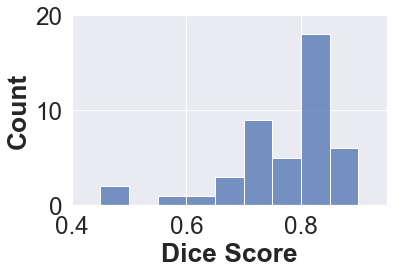

In [24]:
# histogram distribution of DSC
sns.set_context("paper")
sns.set(font_scale = 2.2)
ax = sns.histplot(results_df['Dice Score'],binwidth=0.05, binrange=[0.45,.9])
plt.axis([0.4, 0.95 , 0, 20])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)
plt.savefig('../output/figures_RadAI/figure_2A.tiff',
           dpi=300)

### Figure 3D

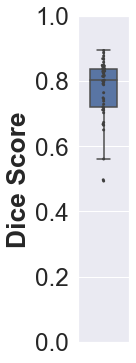

In [25]:
# boxplot of DSC
sns.set(font_scale = 2.2)
fig = plt.figure(figsize = (2,6)) # create a 5 x 5 figure 
ax = sns.boxplot(y="Dice Score", data=results_df, orient="v", fliersize=0)
ax = sns.swarmplot(y="Dice Score", data=results_df, orient="v", color=".25", size=3)
plt.axis([-0.75,0.75,0,1])


plt.ylabel('Dice Score',fontweight = 'bold')
plt.gcf().subplots_adjust(left=0.55)
plt.savefig('../output/figures_RadAI/figure_3.tiff',
           dpi=300)


#### Secondary performance measures (Hausdorff distance & volume)
Two secondary performance measures were assessed, Hausdorff distance and predicted resection volume. Hausdorff distance quantifies the maximal distance between analogous boundary points in ground truth and predicted segmentations. In our analyses we have included the 50% Hausdorff distance, which quantifies the average boundary error in a segmentation, as well as the 95% Hausdorff distance, which has been utilized as an accuracy measure in prominent segmentation challenges (24). In our dataset the median average Hausdorff distance was 1.0 ± 0.02 mm, while the median 95% Hausdorff distance was 4.1 ± 3.3 mm (Figure 3B). This indicates that on average the segmentation was one voxel away from the target boundary and that 95% of boundary points were within 4.1 mm of the target.

When comparing manual and automated segmentation volumes, predicted volumes were slightly smaller (19.8 ± 13.9 ml) than manually labeled segmentations (23.0 ± 17.7 ml), with a significant difference detected in a pairwise t-test (p = 0.02638, t = -2.30). There was a strong correlation between the manual and automated volumes (R = 0.85, p < 0.0001, Figure 3C).


### Figure 3B

In [26]:
# print DSC basic stats
basic_stats(results_df,'50% Hausdorff Distance (mm)')
basic_stats(results_df,'95% Hausdorff Distance (mm)')
basic_stats(results_df,'100% Hausdorff Distance (mm)')
basic_stats(results_df,'Ground Truth Volume (ml)')
basic_stats(results_df,'Predicted Volume (ml)')

# compare predicted and ground truth volumes
print('T-test: predicted versus GT volume')
scipy.stats.ttest_rel( results_df['Predicted Volume (ml)'], results_df['Ground Truth Volume (ml)'])

50% Hausdorff Distance (mm)
Mean (std): 1.04 +/- 0.67
Median (IQR): 1.0 +/- 0.02
Max: 4.03
Min: 0.0

95% Hausdorff Distance (mm)
Mean (std): 6.12 +/- 4.38
Median (IQR): 4.12 +/- 3.34
Max: 22.04
Min: 2.24

100% Hausdorff Distance (mm)
Mean (std): 12.73 +/- 6.74
Median (IQR): 10.06 +/- 7.28
Max: 36.64
Min: 5.48

Ground Truth Volume (ml)
Mean (std): 22.99 +/- 17.66
Median (IQR): 22.21 +/- 22.93
Max: 85.35
Min: 2.35

Predicted Volume (ml)
Mean (std): 19.76 +/- 13.93
Median (IQR): 22.12 +/- 22.28
Max: 76.04
Min: 1.69

T-test: predicted versus GT volume


Ttest_relResult(statistic=-2.2982785112942694, pvalue=0.026356185781229263)

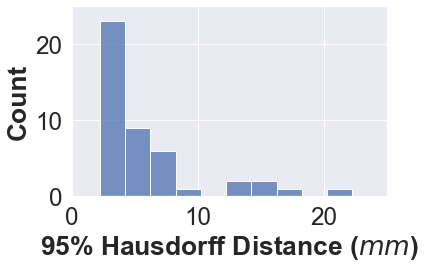

In [27]:
# histogram 95% HD
sns.set_context("paper")
# sns.histplot(hd_df, binwidth=2.5)
sns.set(font_scale = 2.2)
f2b = sns.histplot(results_df['95% Hausdorff Distance (mm)'], binwidth=2)

plt.axis([0, 25, 0, 25])
plt.ylabel('Count',fontweight = 'bold')
plt.xlabel('95% Hausdorff Distance ($mm$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.22, left=0.17)

plt.savefig('../output/figures_RadAI/figure_2B.tiff',
           dpi=300)

### Figure 3C

Pearson's corr: R = 0.8514463350853099 P = 1.2471385364643399e-13
MAE: 5.215457732156576


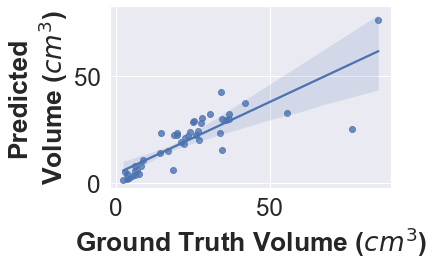

In [28]:
# plot relationship between predicted and ground truth segmentations
sns.set_theme(color_codes=True)
sns.set(font_scale = 2.2)
x, y = pd.Series(gt_vol, name="Ground Truth Volume (cubic cm)"), pd.Series(pred_vol, name="Predicted Volume (cubic cm)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(x, y)
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )

plt.xlabel('Ground Truth Volume ($cm^3$)',fontweight = 'bold')
plt.ylabel('Predicted\nVolume ($cm^3$)',fontweight = 'bold')
plt.gcf().subplots_adjust(bottom=0.25, left=0.25)
plt.savefig('../output/figures_RadAI/figure_2C.tiff',
           dpi=300)

# sns.lineplot(x=[-5,40,85],y=[-5,40,85], dashes=True)
# plt.axis([0, 90, 0, 90])

#### False negatives & false positives
The classifier’s false negative and false positive rates of lesion detection were also assessed. A false negative was defined as the algorithm having no segmentation overlap with the manual segmentation. A false positive was defined as inappropriate segmentation in a control subject. For all resection patients, the classifier correctly lateralized their resection to the appropriate hemisphere and the predicted resection overlapped the ground truth label. This indicates a low false negative rate for lesion detection (effectively 0%). To evaluate the potential for false positives, we separately processed 5 healthy control subjects with no history of neurological disorders. In all 5 control subjects no resection segmentations were produced. Importantly, this indicates the classifier is sensitive to the presence of a resection, not simply localizing the temporal lobe and producing an average resection mask as output.


#### Lesion size relationships
Previous literature found a relationship between lesion size and classifier accuracy as measured by DSC and percent volume difference (PVD) between predicted and manual segmentations (25). To understand whether lesion size contributed to classifier accuracy or PVD error, we partitioned subjects into small (N=17) and large (N=29) resection groups using the same threshold (17.92 ml) previously reported (25). In our model, we found no relationship between the DSC and lesion size (p=0.19, two-sample t-test) though a modest effect was observed when comparing PVD for small and large lesion groups (p = 0.055, two-sample t-test, t = -1.97) which indicates a larger percent error for small lesions. Predicted and actual volumes for small lesions were not significantly different (mean volume: actual = 7.2 ml, predicted = 7.1 ml, p=0.87, two-sample t-test), however large lesions tended towards under-segmentation (mean volume: actual = 32.6 ml, predicted = 27.5 ml, p=0.02, two-sample t-test).


In [29]:
# calculate absolute partial volume difference
results_df['PVD'] = np.multiply( np.abs( (results_df['Ground Truth Volume (ml)'] - results_df['Predicted Volume (ml)']) ) / results_df['Ground Truth Volume (ml)'] , 100)

# define small and large groups using threshold form Gau et al., 2020 (25)
large = results_df[ results_df['Ground Truth Volume (ml)'] >= 17.92 ]
small = results_df[ results_df['Ground Truth Volume (ml)'] < 17.92 ]

# compare small/large DSC
print('Large DSC: ' + str( np.round( np.mean( large['Dice Score'] ) , 2) ) + ' +/- ' + str( np.round( np.std( large['Dice Score']) , 2) ) )
print('Small DSC: ' + str( np.round( np.mean( small['Dice Score'] ) , 2) ) + ' +/- ' + str( np.round( np.std( small['Dice Score']) , 2) ) )
DSC_size_results = scipy.stats.ttest_ind( large['Dice Score'], small['Dice Score'])
print(DSC_size_results)
print(' ')

# compare small/large Percent Volume Difference (PVD)
print('Large PVD: ' + str( np.round( np.mean( large['PVD'] ) , 2) ) + ' +/- ' + str( np.round( np.std( large['PVD']) , 2) ) )
print('Small PVD: ' + str( np.round( np.mean( small['PVD'] ) , 2) ) + ' +/- ' + str( np.round( np.std( small['PVD']) , 2) ) )
PVD_result = scipy.stats.ttest_ind( large['PVD'], small['PVD'])
print( PVD_result )
print(' ')

# compare large lesions volume estimates
print('Large resection volume (actual): ' + str( np.round( np.mean( large['Ground Truth Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( large['Ground Truth Volume (ml)']) , 2) ) )
print('Large resection volume (predicted): ' + str( np.round( np.mean( large['Predicted Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( large['Predicted Volume (ml)']) , 2) ) )
LRV_results = scipy.stats.ttest_rel(large['Ground Truth Volume (ml)'], large['Predicted Volume (ml)'])
print(LRV_results)
print(' ')

# compare small lesions volume estimates
print('Small resection volume (actual): ' + str( np.round( np.mean( small['Ground Truth Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( small['Ground Truth Volume (ml)']) , 2) ) )
print('Small resection volume (predicted): ' + str( np.round( np.mean( small['Predicted Volume (ml)'] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( small['Predicted Volume (ml)']) , 2) ) )
SRV_results = scipy.stats.ttest_rel(small['Ground Truth Volume (ml)'], small['Predicted Volume (ml)'])
print(SRV_results)
print(' ')


Large DSC: 0.79 +/- 0.1
Small DSC: 0.75 +/- 0.07
Ttest_indResult(statistic=1.3429970478751645, pvalue=0.18631908309794945)
 
Large PVD: 19.41 +/- 17.34
Small PVD: 31.04 +/- 20.99
Ttest_indResult(statistic=-1.9662922938681766, pvalue=0.05574153763016433)
 
Large resection volume (actual): 32.6 +/- 15.69
Large resection volume (predicted): 27.47 +/- 11.62
Ttest_relResult(statistic=2.3749135999351756, pvalue=0.024916789172210616)
 
Small resection volume (actual): 7.17 +/- 4.21
Small resection volume (predicted): 7.06 +/- 5.66
Ttest_relResult(statistic=0.16003098484976938, pvalue=0.8748595733796438)
 


#### Comparing surgical approaches

Some text about comparing SAH & ATL

NameError: name 'ATL_df' is not defined

In [7]:
# get SAH and ATL dataframes
combined_df = results_df.merge(demo_df, left_on='subID', right_on='ID')
SAH_df = combined_df[ combined_df['surgery'] == 'SAH' ]
ATL_df = combined_df[ combined_df['surgery'] == 'ATL' ]

# compare DSC
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Dice Score')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','50% Hausdorff Distance (mm)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','95% Hausdorff Distance (mm)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','100% Hausdorff Distance (mm)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Ground Truth Volume (ml)')
compare_stats(ATL_df,'ATL',SAH_df,'SAH','Predicted Volume (ml)')


NameError: name 'results_df' is not defined

In [43]:
combined_df

,subID,Predicted Volume (ml),Ground Truth Volume (ml),Dice Score,50% Hausdorff Distance (mm),95% Hausdorff Distance (mm),100% Hausdorff Distance (mm),PVD,ID,site,gender,age at surgery,age at onset,duration,side,surgery,outcome,age at scan,scan to surgery
0,pat21,28.508000,25.119000,0.837675,1.000000,4.000000,10.000000,13.491779,pat21,VUMC,Male,43.000000,1.000000,45.0,Right,ATL,III-a,46.0,3.000000
1,pat24,5.986000,7.009000,0.837553,0.000000,3.162278,9.000000,14.595520,pat24,VUMC,Female,41.500000,10.000000,33.0,Right,SAH,I-b,43.0,1.500000
2,pat25,2.367000,3.487000,0.717458,1.000000,3.162278,5.477226,32.119300,pat25,VUMC,Male,38.750000,8.000000,32.0,Left,LITT,I-a,40.0,1.250000
3,23_r,20.178795,26.887894,0.763723,1.000000,7.422981,15.960416,24.952117,23_r,HUP,Female,43.000000,NaN,NaN,Right,ATL,NaN,45.0,NaN
4,HUP177,30.589819,28.115273,0.847706,0.690534,14.681632,24.103428,8.801431,HUP177,HUP,Female,39.000000,37.000000,2.0,Left,ATL,I-a,NaN,NaN
5,40_f,22.117615,23.373604,0.813400,0.976562,10.064489,18.091842,5.373536,40_f,HUP,Female,22.000000,NaN,NaN,Left,ATL,NaN,23.0,NaN
6,HUP086_20000729_ISO,29.428482,35.893440,0.857143,0.976562,4.451370,20.507812,18.011531,HUP086_20000729_ISO,HUP,Female,27.000000,5.000000,22.0,Left,ATL,I-a,28.0,0.666667
7,pat04,5.574000,6.337000,0.845941,0.000000,2.449490,7.874008,12.040398,pat04,VUMC,Female,13.916667,0.583333,18.0,Left,SAH,I-a,18.0,4.083333
8,pat07,22.531000,25.877000,0.788010,1.000000,7.000000,12.529964,12.930402,pat07,VUMC,Female,49.000000,33.000000,21.0,Right,ATL,I-a,54.0,5.000000
9,HUP142,1.692773,2.345361,0.728306,0.900000,4.773118,8.114744,27.824621,HUP142,HUP,Male,30.000000,15.000000,15.0,Left,LITT,II-a,NaN,NaN


#### Visual inspection
The largest source of error in estimating resection volume was in patients with resections that extended outside of the temporal lobe, including regions of the parietal lobe. extra-temporal resections were poorly represented in the dataset, with only two such cases. Resections in these patients corresponded to the lowest DSC and involved significant under-segmentation (Figure 4). Additionally, there were cases of over-segmentation in comparison to the ground-truth label, particularly for smaller lesions. Cases of over-segmentation included anterior extension into the sphenoid wing and adjacent cerebral spinal fluid surrounding the resection site.

#### Quantifying surgical remnants
The web application that deploys our pipeline consists of a set of sequential web pages where users can upload MR images, visualize the predicted mask, and save a report of resected brain regions to their local desktop. The initial screen lets the user choose between predicting a mask from a post-operative image and generating a full volumetric report of the affected brain regions or generating the report only if the predicted mask has already been calculated. The report page consists of a volumetric report table, a 3D mask viewer, and optional user feedback (Figure 5). The volumetric report gives the total resected volume and a list of resected brain regions. An embedded 3D mask viewer allows the user to make a quality assessment of the predicted mask against the post-operative image.

Hippocampal remnants have previously been associated with worse surgical outcomes (7). We compared hippocampal remnant volumes using the manual and predicted resection segmentations for a subset of 36 patients with preoperative imaging. One subject was excluded due to poor image registration. There is a strong correlation between hippocampal remnant estimates made using the manual labels and automated segmentation (R = 0.82, P < 0.00001), with a mean absolute error (MAE) of 5% (Figure 6).


#### AAL version

In [ ]:
# Move pre2post files to temporary output directory
#
#
# for folder in os.listdir('../analysis/CFM_results/'):
#     if folder == '.DS_Store':
#         continue 
    
#     if folder[:3] == 'pat':
#         src = '../analysis/CFM_results/' + folder + '/pre2post/pre2post_T1W3D-0001_pre_' + folder + '.nii'
#     else:
#         src = '../analysis/CFM_results/' + folder + '/pre2post/pre2post_' + folder + '_preop.nii.gz'
    
#     dst = '../tmp/pre2post/' + folder + '/pre2post_' + folder + '_preop.nii.gz'
#     output_dir = '../tmp/pre2post/' + folder
#     os.makedirs(output_dir,exist_ok=True)
#     shutil.copyfile(src, dst)

Pearson's corr: R = 0.8694973749599468 P = 1.2228740165125919e-11
MAE: 0.04681883780579484


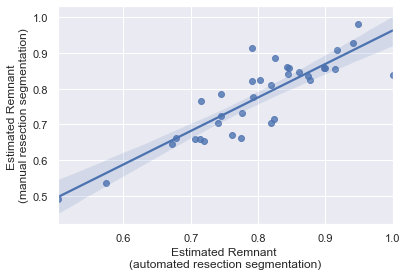

In [17]:
# # load in real and predicted volumes
# HIPP_vols_df = lesion_df = pd.DataFrame(columns=['sub_ID','prior_vol','vol_gt', 'vol_pred','per_gt','per_pred'])
# for folder in os.listdir('../analysis/CFM_results/'):
    
#     # ignore .DS_Store
#     if folder == '.DS_Store':
#         continue 
#     # ignore subject 15_e (no resection mask)
#     if folder == '15_e':
#         continue
#     # ignore subject 30_m (failed registration pipeline)
#     if folder == '30_m':
#         continue
        
#     # load in masks and atlas
#     filename = '../analysis/CFM_results/' + folder + '/resection_mask.nii.gz'
#     mask_gt = ants.image_read(filename)
#     filename = '../analysis/CFM_results/' + folder + '/manual/atlas2post/atlas2post_AAL116_origin_MNI_T1.nii'
#     atlas_gt = ants.image_read(filename)
#     filename = '../analysis/CFM_results/' + folder + '/' + folder + '_predicted_mask.nii.gz'
#     mask_pred = ants.image_read(filename)
#     filename = '../analysis/CFM_results/' + folder + '/atlas2post/atlas2post_AAL116_origin_MNI_T1.nii'
#     atlas_pred = ants.image_read(filename)
#     filename = '../analysis/CFM_results/' + folder + '/atlas2pre/atlas2pre_AAL116_origin_MNI_T1.nii'
#     atlas_preop = ants.image_read(filename)
    
#     # determine if left or right resection (see if resection mask intersects left hippocampus)
#     L_vol = np.sum( np.multiply( mask_gt.numpy(), atlas_gt.numpy() ) == 4101  )
#     if L_vol:
#         ROI_num = 4101
#     else:
#         ROI_num = 4102
#     prior_vol = np.sum( atlas_preop.numpy() == ROI_num )
    
#     # calculate resected hippocampus volumes
#     resected_vol_gt = np.sum( np.multiply( mask_gt.numpy(), atlas_gt.numpy() ) == ROI_num  )
#     resected_vol_pred = np.sum( np.multiply( mask_pred.numpy(), atlas_pred.numpy() ) == ROI_num  )
    
#     # calculate hippocampal remnant volume
#     vol_gt = prior_vol - resected_vol_gt
#     per_gt = (prior_vol - resected_vol_gt) / prior_vol
#     vol_pred = prior_vol - resected_vol_pred
#     per_pred = (prior_vol - resected_vol_pred) / prior_vol
    
#     HIPP_vols_df = HIPP_vols_df.append({'sub_ID': folder,
#                                         'prior_vol': prior_vol,
#                                         'vol_gt': vol_gt,
#                                         'vol_pred': vol_pred,
#                                         'per_gt': per_gt,
#                                         'per_pred': per_pred}, 
#                                        ignore_index=True)

# HIPP_vols_df

# # plot relationship between percent of hippocampus remaining for predicted and ground truth segmentations
# sns.set_theme(color_codes=True)
# x, y = pd.Series(HIPP_vols_df['per_pred'], name="Estimated Remnant \n(automated resection segmentation)"), pd.Series(HIPP_vols_df['per_gt'], name="Estimated Remnant \n(manual resection segmentation)")
# ax = sns.regplot(x=x, y=y)
# r, p = scipy.stats.pearsonr( x, y)
# MAE = sklearn.metrics.mean_absolute_error(HIPP_vols_df['per_gt'], HIPP_vols_df['per_pred'])
# print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
# print( 'MAE: ' + str(MAE) )


#### DKT version

In [13]:
# Segment preop images using DKT atlas
for folder in os.listdir('../analysis/CFM_results/'):
    
    # ignore .DS_Store
    if folder == '.DS_Store':
        continue 
    # ignore subject 15_e (no resection mask)
    if folder == '15_e':
        continue 
    
    # load pre2post image
    if folder[:3] == 'pat':
        filename = '../../DeepResection/analysis/CFM_results/' + folder + '/pre2post/pre2post_T1W3D-0001_pre_' + folder + '.nii'
    else:
        filename = '../../DeepResection/analysis/CFM_results/' + folder + '/pre2post/pre2post_' + folder + '_preop.nii.gz' 
    preop = ants.image_read(filename)
        
    # DKT segmentation
    DKT = antspynet.utilities.desikan_killiany_tourville_labeling(preop, do_preprocessing=True, return_probability_images=False, do_lobar_parcellation=False, antsxnet_cache_directory=None, verbose=False)
    filename = '../../DeepResection/analysis/CFM_results/' + folder + '/atlas2pre/DKT_DL.nii.gz'
    ants.image_write(DKT, filename)

/Users/tcarnold/Desktop/Everything/CNT/Projects/DeepResection/scripts
Pearson's corr: R = 0.8801226319345525 P = 3.269966950876469e-12
MAE: 0.07607110159896618


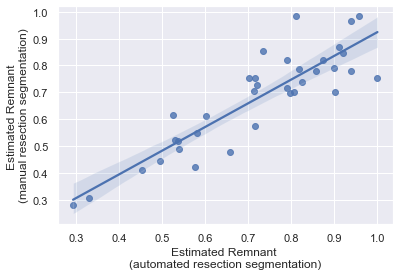

In [11]:
# load in real and predicted volumes
HIPP_vols_df = lesion_df = pd.DataFrame(columns=['sub_ID','prior_vol','vol_gt', 'vol_pred','per_gt','per_pred'])
print(os.getcwd())
for folder in os.listdir('../analysis/CFM_results/'):
    
    # ignore .DS_Store
    if folder == '.DS_Store':
        continue 
    # ignore subject 15_e (no resection mask)
    if folder == '15_e':
        continue
    # ignore subject 30_m (failed registration pipeline)
    if folder == '30_m':
        continue
        
    # load in masks and atlas
    filename = '../analysis/CFM_results/' + folder + '/resection_mask.nii.gz'
    mask_gt = ants.image_read(filename)
    filename = '../analysis/CFM_results/' + folder + '/manual/atlas2post/atlas2post_AAL116_origin_MNI_T1.nii'
    atlas_gt = ants.image_read(filename)
    filename = '../analysis/CFM_results/' + folder + '/' + folder + '_predicted_mask.nii.gz'
    mask_pred = ants.image_read(filename)
    filename = '../analysis/CFM_results/' + folder + '/atlas2pre/DKT_DL.nii.gz'
    atlas_pred = ants.image_read(filename)
    
    # determine if left or right resection (see if resection mask intersects left hippocampus)
    L_vol = np.sum( np.multiply( mask_gt.numpy(), atlas_pred.numpy() ) == 17  )
    if L_vol:
        ROI_num = 17
    else:
        ROI_num = 53
    prior_vol = np.sum( atlas_pred.numpy() == ROI_num )
    
    # get binary mask of only the surgical side hippocampus
    preop_hipp = np.multiply( np.ones( np.shape( atlas_pred.numpy() ) ), atlas_pred.numpy() == ROI_num)
    
    # calculate resected hippocampus volumes
    resected_vol_gt = np.sum( np.multiply( mask_gt.numpy(), preop_hipp ) )
    resected_vol_pred = np.sum( np.multiply( mask_pred.numpy(), preop_hipp) )
    
    # calculate hippocampal remnant volume
    vol_gt = prior_vol - resected_vol_gt
    per_gt = (prior_vol - resected_vol_gt) / prior_vol
    vol_pred = prior_vol - resected_vol_pred
    per_pred = (prior_vol - resected_vol_pred) / prior_vol
    
    HIPP_vols_df = HIPP_vols_df.append({'sub_ID': folder,
                                        'prior_vol': prior_vol,
                                        'vol_gt': vol_gt,
                                        'vol_pred': vol_pred,
                                        'per_gt': per_gt,
                                        'per_pred': per_pred}, 
                                       ignore_index=True)
    
    ### save out Hippocampus and DL remnant ###
    # DL remnant
    inv_mask_pred = np.ones( np.shape( mask_pred.numpy() ) ) -  mask_pred.numpy()
    hipp_img_pred = np.multiply( inv_mask_pred, preop_hipp)
    filename = '../analysis/CFM_results/' + folder + '/atlas2post/hipp_renmant_DL.nii.gz'
    img = ants.from_numpy(hipp_img_pred, origin=atlas_pred.origin, spacing=atlas_pred.spacing, \
                    direction=atlas_pred.direction)
    ants.image_write(img, filename)
    # DL preop hippocampus
    filename = '../analysis/CFM_results/' + folder + '/atlas2pre/hipp_DKT_DL.nii.gz'
    img = ants.from_numpy( preop_hipp, origin=atlas_pred.origin, spacing=atlas_pred.spacing, \
                    direction=atlas_pred.direction)
    ants.image_write(img, filename)

HIPP_vols_df

# plot relationship between percent of hippocampus remaining for predicted and ground truth segmentations
sns.set_theme(color_codes=True)
x, y = pd.Series(HIPP_vols_df['per_pred'], name="Estimated Remnant \n(automated resection segmentation)"), pd.Series(HIPP_vols_df['per_gt'], name="Estimated Remnant \n(manual resection segmentation)")
ax = sns.regplot(x=x, y=y)
r, p = scipy.stats.pearsonr( x, y)
MAE = sklearn.metrics.mean_absolute_error(HIPP_vols_df['per_gt'], HIPP_vols_df['per_pred'])
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )
print( 'MAE: ' + str(MAE) )
plt.savefig('../output/figures_RadAI/figure_6.tiff',
           dpi=300)

## Discussion
We present a deep-learning method to fully automate resection cavity segmentation in postoperative temporal lobe epilepsy patients. Fully automated segmentation provides significant time advantages over manual and semi-automated methods (13,16,28). Our method has several key advantages. First, we trained our model explicitly on TLE patients, who are most frequently operated on for drug-resistant epilepsy. Second, our resection labels are based on gold standard clinical practice (manually segmented by a neuroradiologist with subspecialization in epilepsy imaging and 8 years of experience). Third, we included multi-site data from two epilepsy centers, thus demonstrating potential for multi-center studies. Fourth, we provide a volumetric analysis of resected brain regions for post-hoc analysis. Fifth, we incorporate a graphical user interface (GUI) for easy interpretation of segmentation quality. We demonstrate the clinical utility of our algorithm by quantifying postoperative remnant structures, which have been shown to predict long-term surgical outcome. 

One advantage of the present study is epilepsy patient data was explicitly used during model training. A previous study applied lesion_GNB, a stroke segmentation classifier, to the resection cavity segmentation problem in epilepsy patients (25,29). While lesion_GNB demonstrated some utility in segmenting resections (median DSC 0.58), our classifier achieved a 48% increase (median DSC 0.80) in accuracy. The discrepancy in classifier performance may be caused in part by differences in features between the pathologies, such as lesion intensity and surrounding edema. Resection cavity segmentation has also been attempted in glioblastoma multiforme (GBM) patients (30). Here the classifier was trained explicitly on GBM patient data and classifier performance (median DSC 0.83) was similar to trained radiation oncologists (median DSC 0.85). These studies highlight the importance of developing disease specific classifiers or applying transfer learning to fine-tune models for specific pathologies (31).

Other approaches to boost classifier performance include the incorporation of simulated training data. Pérez-García et al. recently reported the development of EPISURG, a self-supervised resection segmentation classifier that uses exclusively simulated resection data (32). Their classifier achieved a median DSC of 0.805 using 2074 simulated resections, which surpassed their classifier trained using 133 manual labels (median DSC 0.653). This illustrates the significant performance gains possible through innovative data augmentation. However, it is important to note that all versions of their model report false negatives, meaning in some subjects the resection was entirely missed. This is likely due in part to broad inclusion criteria, but false negatives may also be occurring because important features such as gliosis, blood pooling, and brain drift are not included in simulated data.

Automating quantification of resected tissue will catalyze the progress in at least three fields of epilepsy research. First, automated resection segmentation can be used to predict brain network reorganization after surgery. Many patients who are initially seizure free after surgery have a seizure relapse in the long term, possibly due to changes in the networks over time (33). Quantifying brain structures remaining after the surgery, by reliably delineating tissues resected is crucial in predicting such changes and determining patients who are likely to have late recurrences (34). Second, modeling proposed surgeries improves prediction of surgical outcomes (5,35). Precise delineation of resected tissue would facilitate retrospectively analyzing factors associated with seizure outcomes after surgery. Third, our clinical application protocols can be applied prospectively to quantify network changes for alternate surgical strategies before carrying out an actual surgery (6,11). This is particularly useful for patients who are likely to have poor surgical outcomes or in patients in which the site of resection is close to the eloquent cortex.

Our study had several limitations, including a use of strict inclusion criteria, poor representation of extra-temporal resections, and a single image rater. To maximize classifier performance, our initial approach was to select a relatively homogeneous patient population. This limits classifier generalizability to TLE patients and restricts available training data to a smaller sample size. In future studies, criteria will be relaxed to include patients with 1) resections outside the temporal lobe, 2) different surgical approaches and 3) a broader range of clinical imaging sequences. Furthermore, extra-temporal patients were poorly represented in our dataset, which resulted in lower segmentation accuracy for these patients. Increasing representation of extra-temporal resections, either as actual or simulated data, could improve classification for these patients. An additional study limitation was that manual segmentations were only available from a single neuroradiologist. Having a single rater prevents the assessment of inter-rater reliability (IRR) in our study; however IRR has been assessed for resection segmentation by other groups and results are fairly consistent across studies (median DSC 0.84-0.86) (30,32).

In conclusion, we developed a fully automated method for segmenting the resection cavity and quantifying brain regions removed in TLE surgical patients. Our method performance approaches IRR between radiologists while significantly reducing manual input. Automated resection cavity segmentation methods have important implications for predictive models of surgical interventions and consistency across multi-center trials. We openly share all code and model weights for our classifier to enable acceleration towards clinical translation and improvement of epilepsy patient care.



## References

1.  Kwan P, Brodie MJ. Early Identification of Refractory Epilepsy. N Engl J Med.  Massachusetts Medical Society ; 2000;342(5):314–319. doi: 10.1056/NEJM200002033420503.
2.     Asadi-Pooya AA, Stewart GR, Abrams DJ, Sharan A. Prevalence and Incidence of Drug-Resistant Mesial Temporal Lobe Epilepsy in the United States. World Neurosurg. Elsevier Inc.; 2017. p. 662–666. doi: 10.1016/j.wneu.2016.12.074.
3.     Wiebe S, Blume WT, Girvin JP, Eliasziw M. A Randomized, Controlled Trial of Surgery for Temporal-Lobe Epilepsy. N Engl J Med. Massachusetts Medical Society; 2001;345(5):311–318. doi: 10.1056/NEJM200108023450501.
4.     Bonilha L, Keller SS. Quantitative MRI in refractory temporal lobe epilepsy: relationship with surgical outcomes. Quant Imaging Med Surg. 2015;5(2):204–224. doi: 10.3978/j.issn.2223-4292.2015.01.01.
5.     Koepp MJ, Galovic M, Baudracco I, et al. Association of piriform cortex resection with surgical outcomes in patients with temporal lobe epilepsy. JAMA Neurol. American Medical Association; 2019;76(6):690–700. doi: 10.1001/jamaneurol.2019.0204.
6.     Taylor PN, Sinha N, Wang Y, et al. The impact of epilepsy surgery on the structural connectome and its relation to outcome. NeuroImage Clin. Elsevier Inc.; 2018;18:202–214. doi: 10.1016/j.nicl.2018.01.028.
7.     Noulhiane M, Samson S, Clémenceau S, Dormont D, Baulac M, Hasboun D. A volumetric MRI study of the hippocampus and the parahippocampal region after unilateral medial temporal lobe resection. J Neurosci Methods. Elsevier; 2006;156(1–2):293–304. doi: 10.1016/j.jneumeth.2006.02.021.
8.     Jirsa VK, Proix T, Perdikis D, et al. The Virtual Epileptic Patient: Individualized whole-brain models of epilepsy spread. Neuroimage. Academic Press; 2017;145:377–388. doi: 10.1016/J.NEUROIMAGE.2016.04.049.
9.     Khambhati AN, Davis KA, Lucas TH, et al. Virtual Cortical Resection Reveals Push-Pull Network Control Preceding Seizure Evolution. Neuron. International Machine Learning Society; 2016;91(5):1170–1182. doi: 10.1016/j.neuron.2016.07.039.
10.     Sinha N, Dauwels J, Kaiser M, et al. Predicting neurosurgical outcomes in focal epilepsy patients using computational modelling. Brain. Oxford University Press; 2017;140(2):319–332. doi: 10.1093/brain/aww299.
11.     Kini LG, Bernabei JM, Mikhail F, et al. Virtual resection predicts surgical outcome for drug-resistant epilepsy. Brain. Oxford University Press; 2019;142(12):3892–3905. doi: 10.1093/brain/awz303.
12.     Yao AD, Cheng DL, Pan I, Kitamura F. Deep Learning in Neuroradiology: A Systematic Review of Current Algorithms and Approaches for the New Wave of Imaging Technology. Radiol Artif Intell. 2020;2(2):e190026. doi: 10.1148/ryai.2020190026.
13.     Ronneberger O, Fischer P, Brox T. U-Net: Convolutional Networks for Biomedical Image Segmentation. Springer, Cham; 2015. p. 234–241. doi: 10.1007/978-3-319-24574-4_28.
14.     Chassagnon G, Zacharaki EI, Benmostefa N, Revel M. Deep Learning – based Approach for Automated Assessment of Interstitial Lung Disease in Systemic Sclerosis on CT Images. 2020;(6).
15.     Duncan JS, Winston GP, Koepp MJ, Ourselin S. Brain imaging in the assessment for epilepsy surgery. Lancet Neurol. Elsevier; 2016;15(4):420–433. doi: 10.1016/S1474-4422(15)00383-X.
16.     Yushkevich PA, Piven J, Hazlett HC, et al. User-guided 3D active contour segmentation of anatomical structures: Significantly improved efficiency and reliability. Neuroimage. Academic Press; 2006;31(3):1116–1128. doi: 10.1016/J.NEUROIMAGE.2006.01.015.
17.     Abadi M, Barham P, Chen J, et al. Tensorflow: A system for large-scale machine learning. USENIX Symp Oper Syst Des Implement. 2016;265–283.
18.     Erickson BJ, Cai J. Magician’s Corner: 4. Image Segmentation with U-Net. Radiol Artif Intell. 2020;2(1):e190161. doi: 10.1148/ryai.2020190161.
19.     Deng J, Dong W, Socher R, Li L-J, Kai Li, Li Fei-Fei. ImageNet: A large-scale hierarchical image database. Institute of Electrical and Electronics Engineers (IEEE); 2010. p. 248–255. doi: 10.1109/cvpr.2009.5206848.
20.     Tan M, Le Q V. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. PMLR; 2019 May. http://proceedings.mlr.press/v97/tan19a.html. Accessed March 8, 2021.
21.     Perez L, Wang J. The Effectiveness of Data Augmentation in Image Classification using Deep Learning. 2017; http://arxiv.org/abs/1712.04621. Accessed July 18, 2019.
22.     Dice LR. Measures of the Amount of Ecologic Association Between Species. Ecology. John Wiley & Sons, Ltd; 1945;26(3):297–302. doi: 10.2307/1932409.
23.     Maier-Hein L, Eisenmann M, Reinke A, et al. Why rankings of biomedical image analysis competitions should be interpreted with care. Nat Commun. Nature Publishing Group; 2018;9(1). doi: 10.1038/s41467-018-07619-7.
24.     Bakas S, Reyes M, Jakab A, et al. Identifying the Best Machine Learning Algorithms for Brain Tumor Segmentation, Progression Assessment, and Overall Survival Prediction in the BRATS Challenge. 2018; http://arxiv.org/abs/1811.02629. Accessed July 18, 2019.
25.     Gau K, Schmidt CSM, Urbach H, et al. Accuracy and practical aspects of semi- and fully automatic segmentation methods for resected brain areas. Neuroradiology. Springer Science and Business Media Deutschland GmbH; 2020;62(12):1637–1648. doi: 10.1007/s00234-020-02481-1.
26.     Avants, Brian B., Tustison, Nick, Song G. Advanced normalization tools (ANTS). Insight j 2. 2009;1–35.
27.     Barnett AG. Regression to the mean: what it is and how to deal with it. Int J Epidemiol. Oxford Academic; 2004;34(1):215–220. doi: 10.1093/ije/dyh299.
28.     Atsina K-B, Gorniak R, Sharan A, Wu C. A Methodology for Systematic Volumetric Analysis of Perioperative Cranial Imaging in Neurosurgical Patients. JHN J. Thomas Jefferson University; 2016;11(2):2. doi: 10.29046/jhnj.011.2.002.
29.     Griffis JC, Allendorfer JB, Szaflarski JP. Voxel-based Gaussian naïve Bayes classification of ischemic stroke lesions in individual T1-weighted MRI scans. J Neurosci Methods. Elsevier; 2016;257:97–108. doi: 10.1016/j.jneumeth.2015.09.019.
30.     Ermiş E, Jungo A, Poel R, et al. Fully automated brain resection cavity delineation for radiation target volume definition in glioblastoma patients using deep learning. Radiat Oncol. BioMed Central Ltd.; 2020;15(1):100. doi: 10.1186/s13014-020-01553-z.
31.     Pan SJ, Yang Q. A survey on transfer learning. IEEE Trans. Knowl. Data Eng. 2010. p. 1345–1359. doi: 10.1109/TKDE.2009.191.
32.     Pérez-García F, Rodionov R, Alim-Marvasti A, Sparks R, Duncan JS, Ourselin S. Simulation of Brain Resection for Cavity Segmentation Using Self-supervised and Semi-supervised Learning. Lect Notes Comput Sci (including Subser Lect Notes Artif Intell Lect Notes Bioinformatics). Springer Science and Business Media Deutschland GmbH; 2020. p. 115–125. doi: 10.1007/978-3-030-59716-0_12.
33.     de Tisi J, Bell GS, Peacock JL, et al. The long-term outcome of adult epilepsy surgery, patterns of seizure remission, and relapse: a cohort study. Lancet. Elsevier; 2011;378(9800):1388–1395. doi: 10.1016/S0140-6736(11)60890-8.
34.     Morgan VL, Rogers BP, Anderson AW, Landman BA, Englot DJ. Divergent network properties that predict early surgical failure versus late recurrence in temporal lobe epilepsy. J Neurosurg. American Association of Neurological Surgeons; 2020;132(5):1324–1333. doi: 10.3171/2019.1.JNS182875.
35.     Sinha N, Wang Y, Moreira da Silva N, et al. Structural Brain Network Abnormalities and the Probability of Seizure Recurrence After Epilepsy Surgery. Neurology. NLM (Medline); 2021;96(5):e758–e771. doi: 10.1212/WNL.0000000000011315.